In [25]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
from util import cache, constants
import importlib

importlib.reload(cache)

<module 'util.cache' from '/Users/cameron/Documents/mlx/hackernews/util/cache.py'>

In [21]:
Path("./data/cache").mkdir(exist_ok=True)

postsByDomain = cache.query("postsByDomain", f"""SELECT
    SUBSTRING(
        url FROM
        '://([^/]+)'
    ) AS domain,
    count(*) AS number_of_posts,
    avg(score) AS avg_score,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY score) AS median_score
    FROM {constants.ITEMS_TABLE}
    WHERE type = 'story' AND url IS NOT null AND score IS NOT null AND score != 1
    GROUP BY domain
    HAVING count(*) > 10
""")

postsByDomain.head()

,domain,number_of_posts,avg_score,median_score
0,000fff.org,22,33.772727,23.5
1,00f.net,31,51.193548,3.0
2,0110.be,15,27.400000,4.0
3,01.org,27,67.777778,12.0
4,0.30000000000000004.com,12,146.583333,2.0


In [7]:
popular_sites = pd.read_csv("./data/top10milliondomains.csv.zip")
popular_sites.set_index('Rank', inplace=True)
popular_sites.rename(columns={'Domain': 'domain', 'Open Page Rank': 'page_rank_score'}, inplace=True)
popular_sites.head()

,domain,page_rank_score
Rank,,
1,facebook.com,10.0
2,fonts.googleapis.com,10.0
3,youtube.com,10.0
4,google.com,10.0
5,googletagmanager.com,10.0


In [ ]:
postsByDomainWithRanks = postsByDomain.merge(popular_sites, on='domain', how='left')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.scatter(postsByDomainWithRanks['page_rank_score'], postsByDomainWithRanks['median_score'])
ax1.set_xlabel("Page Rank Score")
ax2.set_ylabel("Median Score")
corr = abs(postsByDomainWithRanks['page_rank_score'].corr(postsByDomainWithRanks['median_score']))
ax1.set_title(f"Median Score vs Page Rank Score (corr. = {corr})")

ax2.scatter(postsByDomainWithRanks['page_rank_score'], postsByDomainWithRanks['avg_score'])
ax2.set_xlabel("Page Rank Score")
ax2.set_ylabel("Average Score")
corr = abs(postsByDomainWithRanks['page_rank_score'].corr(postsByDomainWithRanks['avg_score']))
plt.title(f"Average Score vs Page Rank Score (corr. = {corr})")

plt.show()

: 

In conclusion there is no reliable correlation between domain popularity and upvotes

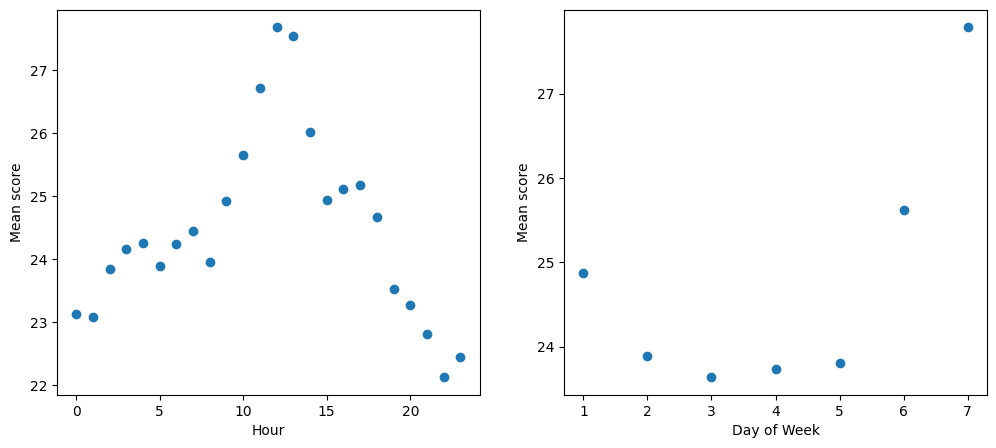

In [ ]:
postsByHour = cache.query("postsByHour", f"""SELECT
    extract(hour from time) AS hour,
    count(*) AS number_of_posts,
    avg(score) AS avg_score,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY score) AS median_score
    FROM {constants.ITEMS_TABLE}
    WHERE type = 'story' AND url IS NOT null AND score IS NOT null AND score != 1
    GROUP BY hour
    ORDER BY hour ASC
""")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(postsByHour['hour'], postsByHour['avg_score'])
ax1.set_xlabel("Hour")
ax1.set_ylabel("Mean score")

postsByDayOfWeek = cache.query("postsByDayOfWeek", f"""SELECT
    extract(isodow from time) AS day_of_week,
    count(*) AS number_of_posts,
    avg(score) AS avg_score,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY score) AS median_score
    FROM {constants.ITEMS_TABLE}
    WHERE type = 'story' AND url IS NOT null AND score IS NOT null AND score != 1
    GROUP BY day_of_week
    ORDER BY day_of_week ASC
""")

ax2.scatter(postsByDayOfWeek['day_of_week'], postsByDayOfWeek['avg_score'])
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Mean score")

plt.show()

In [ ]:
postsByScore = cache.query("postsByScore", f"""SELECT
                            score,
                            count(*)
                            FROM {constants.ITEMS_TABLE}
                            WHERE type = 'story' AND url IS NOT null AND score IS NOT null AND score < 100
                            GROUP BY score
                            ORDER BY score ASC
                        """)

postsByScore.head()

: 

In [ ]:
postsWithUsers = cache.query("postsWithUsers", f"""SELECT
                            *
                            FROM {constants.ITEMS_TABLE}
                            INNER JOIN {constants.USERS_TABLE} ON {constants.ITEMS_TABLE}.by = {constants.USERS_TABLE}.id
                            WHERE type = 'story' AND url IS NOT null AND score IS NOT null AND score < 100
                            ORDER BY score ASC
                            LIMIT 10
                        """)

postsWithUsers.head()

,id,dead,type,by,time,text,parent,kids,url,score,title,descendants,id,created,karma,about,submitted
0,10560570,None,story,angchappy,2015-11-13 16:14:14,None,None,[10561274],http://onc.al/UCfCx,-1,The DevOps Democracy,1,angchappy,2015-05-08 19:30:34,6,None,"[12464451, 10560570, 10499746, 10426341, 10135..."
1,4150348,None,story,bwo,2012-06-23 08:47:41,,None,None,http://www.extrawurst.org/blog11/2012/06/wooga...,0,Woogas HTML5 game and lesscss,0,bwo,2012-06-23 08:47:14,1,None,"[4806722, 4607697, 4150348]"
2,4600008,None,story,portwd,2012-10-02 01:05:04,,None,None,http://blog.portwd.com/music-research/songs-th...,0,Songs that retell a work of literature – music...,0,portwd,2012-10-02 00:02:57,2,None,"[4757767, 4611756, 4611752, 4610464, 4610449, ..."
3,2100272,True,story,DerFuxx,2011-01-13 16:20:44,,None,None,http://ps3epicfail.com/,0,Sony please sue me too,-1,DerFuxx,2011-01-13 16:20:08,1,None,[2100272]
4,4750302,True,story,francois580,2012-11-06 19:49:21,None,None,None,http://www.je-geldzaken.be/een-goedkope-honden...,0,Een goedkope hondenverzekering voor de beste v...,-1,francois580,2012-01-29 15:25:35,1,None,"[41789253, 41764679, 41730936, 41709045, 41648..."


We can see that there are a huge number of posts with 1 upvote, and very few with 0. 